In [1]:
# Library import
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import numpy as np
from collections import Counter
from sklearn import metrics

import matplotlib.pyplot as plt

# Constants definition
batch_size = 1024
num_classes = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# We need to create a function for transforming the original labels from fashion MNIST into the new labels proposed

def create_target_dict():
  target_dict = dict()
   # Upper part
  target_dict["0"] = 0
  target_dict["2"] = 0
  target_dict["4"] = 0
  target_dict["6"] = 0
  # Bottom part
  target_dict["1"] = 1
  # One piece
  target_dict["3"] = 2
  # Footwear
  target_dict["5"] = 3
  target_dict["7"] = 3
  target_dict["9"] = 3
  # Bags
  target_dict["8"] = 4
  return target_dict

def transform_target_fashion_labels(label):
  target_dict = create_target_dict()
  return target_dict[str(label)]

In [3]:
# Loading datasets and dataloaders for data exploration
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])


test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

train_set = torchvision.datasets.FashionMNIST('./fashion_data', train=True, download=True, transform=train_transforms, target_transform=transform_target_fashion_labels)
test_set = torchvision.datasets.FashionMNIST('./fashion_data', train=False, download=True, transform=test_transforms, target_transform=transform_target_fashion_labels)

100%|██████████| 26421880/26421880 [00:02<00:00, 12296264.22it/s]


Extracting ./fashion_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./fashion_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 217312.49it/s]


Extracting ./fashion_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./fashion_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3906205.47it/s]


Extracting ./fashion_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./fashion_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 18759580.36it/s]

Extracting ./fashion_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./fashion_data/FashionMNIST/raw



Training set: 60000 samples
Test set: 10000 samples


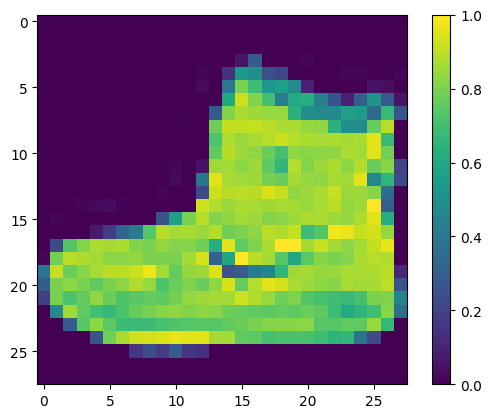

In [4]:
#Lets take a look to the data
print("Training set: {} samples" .format(len(train_set)))
print("Test set: {} samples" .format(len(test_set)))


def show_sample(sample):
  plt.figure()
  plt.imshow(sample)
  plt.colorbar()
  plt.grid(False)
  plt.show()

# First index is for sample index.
# Second index is for selecting the image and not the label.
# Third index is for removing the batch size from the array dimensions
show_sample(train_set[0][0][0])

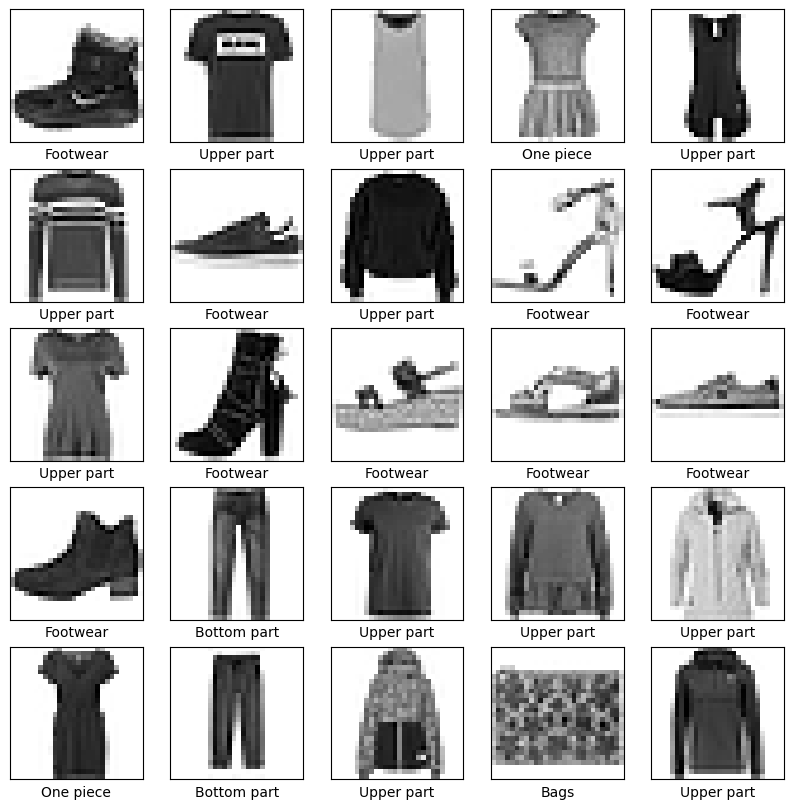

In [5]:
# We will check some samples side by side with its class

def get_label_dict():
  label_dict = dict()
  label_dict["0"] = "Upper part"
  label_dict["1"] = "Bottom part"
  label_dict["2"] = "One piece"
  label_dict["3"] = "Footwear"
  label_dict["4"] = "Bags"
  return label_dict

def plot_samples_grid(dataset):
  plt.figure(figsize=(10,10))
  label_dict = get_label_dict()
  for i in range(25):
      plt.subplot(5,5,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(dataset[i][0][0], cmap=plt.cm.binary)
      plt.xlabel(label_dict[str(dataset[i][1])])
  plt.show()

plot_samples_grid(train_set)


In [6]:
# Lastly, take a look at the label distribution

train_labels = [sample[1] for sample in train_set]
print(Counter(train_labels))
test_labels = [sample[1] for sample in test_set]
print(Counter(test_labels))

Counter({0: 24000, 3: 18000, 2: 6000, 1: 6000, 4: 6000})
Counter({0: 4000, 3: 3000, 1: 1000, 2: 1000, 4: 1000})


In [7]:
# Create the dataloaders for training
def get_all_dataloaders(train_val_set, test_set):
  generator1 = torch.Generator().manual_seed(42)
  train_subset, val_subset = torch.utils.data.random_split(train_val_set, [0.8, 0.2], generator=generator1)
  train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size, shuffle=False)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
  return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = get_all_dataloaders(train_set, test_set)

In [8]:
# Lets take a look at the loaders
x_batch, y_batch = next(iter(train_loader))
print("Training set: {} samples - Max value: {} - Min value: {}".format(len(train_loader.dataset),
                                                                        x_batch.max(), x_batch.min()))
x_batch, y_batch = next(iter(val_loader))
print("Test set: {} samples - Max value: {} - Min value: {}".format(len(val_loader.dataset),
                                                                    x_batch.max(), x_batch.min()))
x_batch, y_batch = next(iter(test_loader))
print("Test set: {} samples - Max value: {} - Min value: {}".format(len(test_loader.dataset),
                                                                    x_batch.max(), x_batch.min()))

print("Example batch shape: {}".format(x_batch.shape))


Training set: 48000 samples - Max value: 1.0 - Min value: 0.0
Test set: 12000 samples - Max value: 1.0 - Min value: 0.0
Test set: 10000 samples - Max value: 1.0 - Min value: 0.0
Example batch shape: torch.Size([1024, 1, 28, 28])


In [9]:
# We'll start with a VGG net
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        # Black and white images, so 1 channel in the first conv
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), padding=1)
        self.mp1 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1)
        self.mp2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3, 3), padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=(3, 3), padding=1)
        # Add one padding to this pool so the image fits on the model
        self.mp3 = nn.MaxPool2d(kernel_size=(2, 2), padding=1)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=(3, 3), padding=1)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=(3, 3), padding=1)
        self.mp4 = nn.MaxPool2d(kernel_size=(2, 2))
        self.conv7 = nn.Conv2d(512, 512, kernel_size=(3, 3), padding=1)
        self.conv8 = nn.Conv2d(512, 512, kernel_size=(3, 3), padding=1)
        self.mp5 = nn.MaxPool2d(kernel_size=(2, 2))


        # Flatten at forward!
        self.features1 = nn.Linear(512, 512)
        self.features2 = nn.Linear(512, 512)
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.mp1(self.conv1(x))  # 28x28 -> 14x14 @ 32
        out = self.mp2(self.conv2(out))  # 14x14 -> 7x7 @ 64
        out = self.mp3(self.conv4(self.conv3(out)))  # 7x7 -> 4x4 @ 128
        out = self.mp4(self.conv6(self.conv5(out)))  # 4x4 -> 2x2 @ 256
        out = self.mp5(self.conv8(self.conv7(out)))  # 2x2 -> 1x1 @ 512
        out = out.view(out.size(0), -1)  # Flatten
        out = self.features2(self.features1(out))  # 512 -> 512
        out = self.classifier(out)  # 512 -> num_classes (5)
        return out

# We'll also try a multi-layer perceptron
class Perceptron(nn.Module):
    def __init__(self):
        super(Perceptron, self).__init__()
        # Black and white images, so 1 channel in the first conv
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(784, 512)
        self.relu1 = nn.ReLU()
        self.dense2 = nn.Linear(512, 512)
        self.relu2 = nn.ReLU()
        self.dense3 = nn.Linear(512, 512)
        self.relu3 = nn.ReLU()
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.flatten(x) # 28x28 -> 784
        out = self.relu1(self.dense1(out)) # 784 -> 512
        out = self.relu2(self.dense2(out)) # 512 -> 512
        out = self.relu3(self.dense3(out)) # 512 -> 512
        out = self.classifier(out)  # 512 -> num_classes (5)
        return out

In [10]:
def epoch_train(net, train_loader, optimizer, criterion):
  train_loss, train_correct = 0, 0
  net.train()
  for inputs, targets in train_loader:
      # data is a list of [inputs, labels]
      inputs, targets = inputs.to(device), targets.to(device)
      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      # Clip gradients to avoid NaN issues
      torch.nn.utils.clip_grad_norm_(net.parameters(), 0.1)
      optimizer.step()
      # get the index of the max log-probability
      _, pred = outputs.max(1)
      train_correct += pred.eq(targets).sum().item()

      # print statistics
      train_loss += loss.item()

  train_loss /= len(train_loader.dataset)
  return train_loss, train_correct

def epoch_val(net, val_loader, criterion):
  net.eval()
  val_loss, val_correct = 0, 0
  with torch.no_grad():
      for inputs, targets in val_loader:
          inputs, targets = inputs.to(device), targets.to(device)
          outputs = net(inputs)
          val_loss += criterion(outputs, targets).item()
          # get the index of the max log-probability
          _, pred = outputs.max(1)
          val_correct += pred.eq(targets).sum().item()

  val_loss /= len(val_loader.dataset)
  return val_loss, val_correct

# Start training
def train_model(net, train_loader, val_loader, epochs, optimizer, criterion):
  print("\n---- Start Training ----")
  # Variables initialization
  best_accuracy = -1
  accuracy_list = list()
  val_accuracy_list = list()
  loss_list = list()
  val_loss_list = list()
  best_model_path = "./best_model_weights"



  for epoch in range(epochs):

    # Train
    train_loss, train_correct = epoch_train(net, train_loader, optimizer, criterion)
    # Validation
    val_loss, val_correct = epoch_val(net, val_loader, criterion)


    # Print epoch statistics
    # Get current learning rate via the optimizer
    for param_group in optimizer.param_groups:
      current_lr = param_group['lr']

    train_accuracy = 100. * train_correct / len(train_loader.dataset)
    val_accuracy = 100. * val_correct / len(val_loader.dataset)
    print("[Epoch {}] LR: {:.3f} - Train Loss: {:.5f} - Val Loss: {:.5f} - Train Accuracy: {:.2f}% - Val Accuracy: {:.2f}%".format(
          epoch + 1,
          current_lr,
          train_loss,
          val_loss,
          train_accuracy,
          val_accuracy
    ))

    # For later plots
    accuracy_list.append(train_accuracy)
    val_accuracy_list.append(val_accuracy)
    loss_list.append(train_loss)
    val_loss_list.append(val_loss)

    # If model is the best so far, we store it
    if val_accuracy > best_accuracy:
      print("New best, saving model...")
      best_accuracy = val_accuracy
      best_weights = net.state_dict()
      torch.save(best_weights, best_model_path)

    optimizer.step()

  print('Finished Training')
  # We set the weights for the model which gave the best results
  net.load_state_dict(best_weights)
  print("Best Test accuracy: {:.2f}".format(best_accuracy))
  return [accuracy_list, val_accuracy_list, loss_list, val_loss_list]

In [11]:
# Check the evolution of the model

# summarize history for accuracy
def show_accuracy_plot(epochs, accuracy_list, val_accuracy_list):
  epochs_list = range(1,epochs+1)
  plt.plot(epochs_list, accuracy_list)
  plt.plot(epochs_list, val_accuracy_list)
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

def show_loss_plot(epochs_list, loss_list, val_loss_list):
  epochs_list = range(1,epochs+1)
  # summarize history for loss
  plt.plot(epochs_list, loss_list)
  plt.plot(epochs_list, val_loss_list)
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

In [12]:
# Lets see the final metrics for the model

def test_model(net, test_loader):
   net.eval()
   pred=list()
   with torch.no_grad():
    for inputs, targets in test_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = net(inputs)
      # get the index of the max log-probability
      pred += outputs.cpu().max(1)[1].tolist()

    return pred

In [13]:
# Review failed classifications
def get_missclassified_indexes(test_labels, pred):
  np_test_y = np.asarray(test_labels)
  np_pred_y = np.asarray(pred)
  np_eq_array = np.equal(np_test_y, np_pred_y)
  return np.where(np_eq_array==0)

def show_missclassified_grid(failed_indexes, test_loader, pred, test_labels):
  L = 5
  W = 5
  fig, axes = plt.subplots(L, W, figsize = (16,16))
  axes = axes.ravel()

  for i in np.arange(0, L * W):
      sample_index = failed_indexes[0][i]
      axes[i].imshow(test_loader.dataset[sample_index][0][0])
      axes[i].set_title(f"Prediction Class = {pred[sample_index]:0.1f}\n Original Class = {test_labels[sample_index]:0.1f}")
      axes[i].axis('off')
  plt.subplots_adjust(wspace=0.5)

In [14]:
def test_net(net, train_loader, val_loader, test_loader, epochs):
  # Instantiating the network and printing its architecture
  net = net.to(device)
  print(net)
  # Training hyperparameters
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(net.parameters(), lr=0.1, weight_decay=1e-6)

  # Train the model
  accuracy_list, val_accuracy_list, loss_list, val_loss_list = train_model(net, train_loader, val_loader, epochs, optimizer, criterion)

  # Print training statistics
  show_accuracy_plot(epochs, accuracy_list, val_accuracy_list)
  show_loss_plot(epochs, loss_list, val_loss_list)

  # Print test metrics
  pred = test_model(net, test_loader)
  print(metrics.classification_report(test_labels, pred))
  print(metrics.confusion_matrix(test_labels, pred))

  # Review failures

  failed_indexes = get_missclassified_indexes(test_labels, pred)
  show_missclassified_grid(failed_indexes, test_loader, pred, test_labels)

VGG(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mp1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mp2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mp3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=1, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (mp4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv7): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding

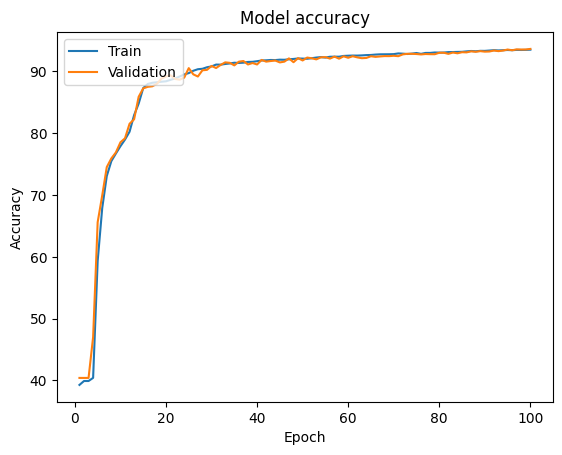

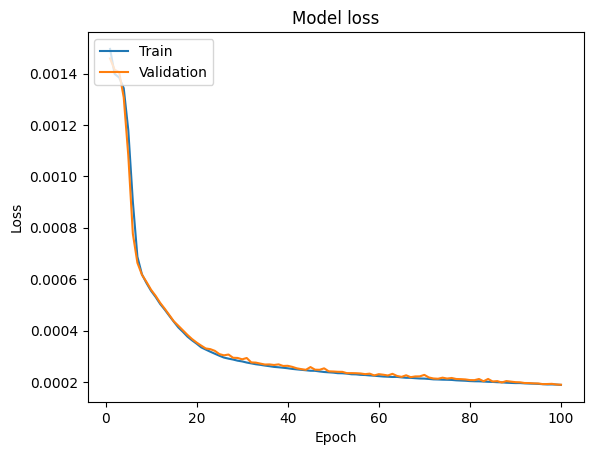

              precision    recall  f1-score   support

           0       0.89      0.96      0.92      4000
           1       0.93      0.92      0.93      1000
           2       0.86      0.59      0.70      1000
           3       1.00      1.00      1.00      3000
           4       0.93      0.93      0.93      1000

    accuracy                           0.93     10000
   macro avg       0.92      0.88      0.90     10000
weighted avg       0.93      0.93      0.92     10000

[[3838   22   72    1   67]
 [  55  919   25    0    1]
 [ 361   44  592    0    3]
 [   1    0    0 2996    3]
 [  52    2    1   14  931]]


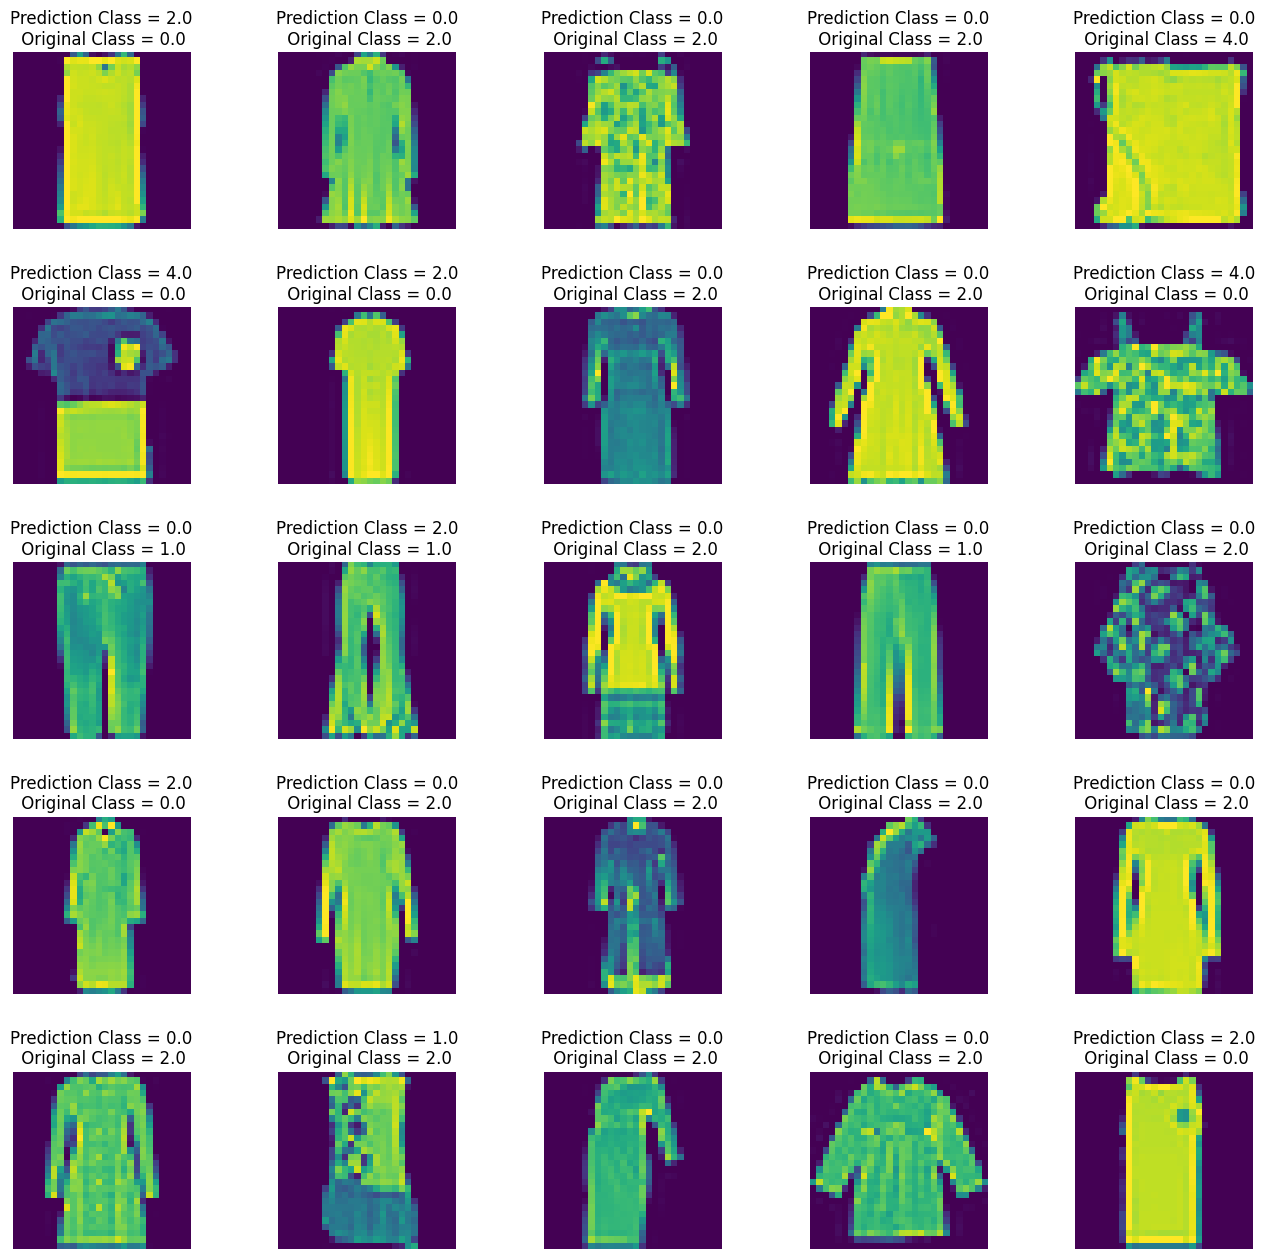

In [15]:
# Training hyperparameters
epochs=100
test_net(VGG(), train_loader, val_loader, test_loader, epochs)

Perceptron(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=784, out_features=512, bias=True)
  (relu1): ReLU()
  (dense2): Linear(in_features=512, out_features=512, bias=True)
  (relu2): ReLU()
  (dense3): Linear(in_features=512, out_features=512, bias=True)
  (relu3): ReLU()
  (classifier): Linear(in_features=512, out_features=5, bias=True)
)

---- Start Training ----
[Epoch 1] LR: 0.100 - Train Loss: 0.00146 - Val Loss: 0.00137 - Train Accuracy: 39.60% - Val Accuracy: 40.40%
New best, saving model...
[Epoch 2] LR: 0.100 - Train Loss: 0.00125 - Val Loss: 0.00116 - Train Accuracy: 49.04% - Val Accuracy: 67.22%
New best, saving model...
[Epoch 3] LR: 0.100 - Train Loss: 0.00101 - Val Loss: 0.00090 - Train Accuracy: 69.11% - Val Accuracy: 69.56%
New best, saving model...
[Epoch 4] LR: 0.100 - Train Loss: 0.00077 - Val Loss: 0.00068 - Train Accuracy: 69.69% - Val Accuracy: 70.40%
New best, saving model...
[Epoch 5] LR: 0.100 - Train Loss: 0.00057 - Val Loss: 

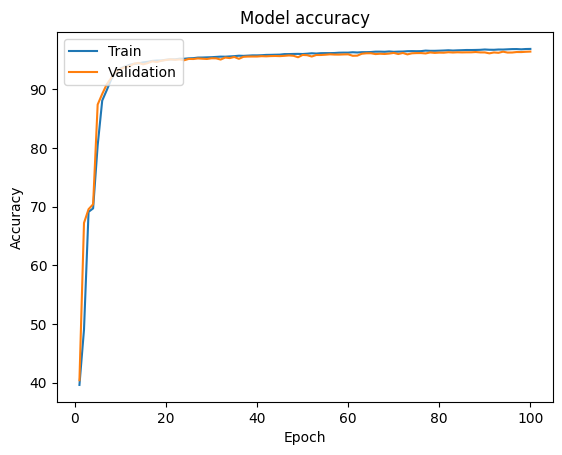

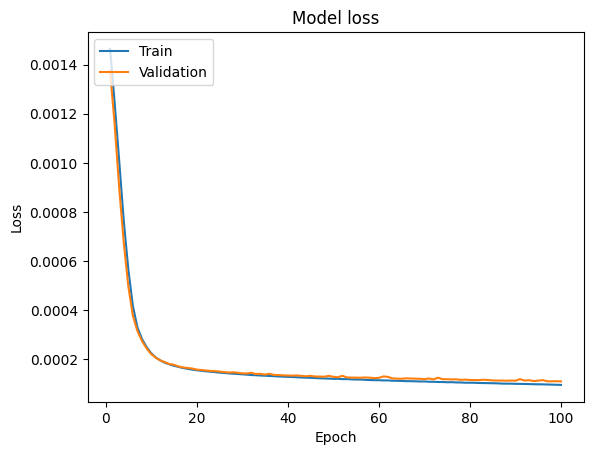

              precision    recall  f1-score   support

           0       0.93      0.98      0.95      4000
           1       0.99      0.95      0.97      1000
           2       0.91      0.77      0.84      1000
           3       1.00      1.00      1.00      3000
           4       0.97      0.92      0.94      1000

    accuracy                           0.96     10000
   macro avg       0.96      0.93      0.94     10000
weighted avg       0.96      0.96      0.96     10000

[[3931    1   44    2   22]
 [  24  955   21    0    0]
 [ 215    7  774    0    4]
 [   2    0    1 2992    5]
 [  68    1    6    6  919]]


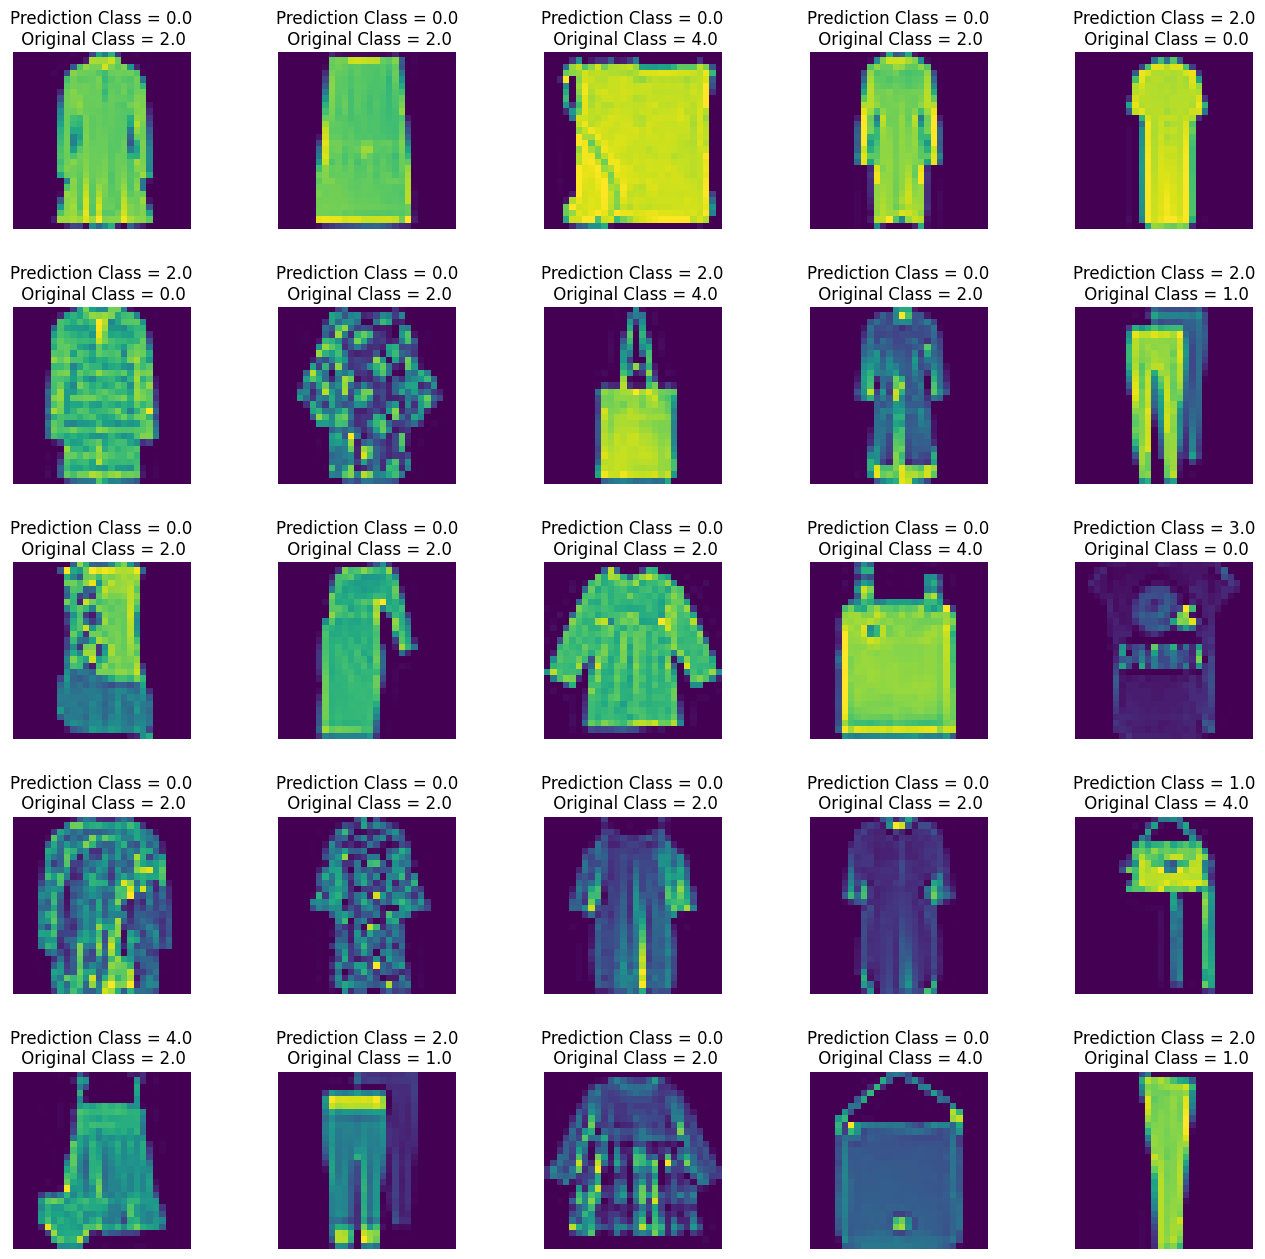

In [16]:
epochs=100
test_net(Perceptron(), train_loader, val_loader, test_loader, epochs)